In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from nltk import WordNetLemmatizer
import spacy
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTEN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

In [2]:
df=pd.read_csv('H:/ExcelR Data Science/Project P72/emails1_edit.txt')
df.drop(['Unnamed: 0', 'filename', 'Message-ID'],axis=1,inplace=True)
df.head()

,content,Class
0,eat shit\r\n\r\n\r\n\r\n\r\nJohn J Lavorato@ex...,Abusive
1,fuck you,Abusive
2,Gentlemen:\r\nThe following champagne is avail...,Abusive
3,sorry i've taken so long...just been trying to...,Abusive
4,asshole\r\n\r\n\r\n\r\n\r\nJohn J Lavorato@exc...,Abusive


## Exploratory Data Analysis

In [3]:
# checking for null values in entire dataframe
df.isnull().sum()

content    0
Class      0
dtype: int64

In [4]:
# Checking for duplicates
df.duplicated().sum()

23420

In [5]:
# Dropping duplicates
df.drop_duplicates(keep='first',inplace=True)
df.reset_index(drop=True,inplace=True)
print('Shape of dataframe after dropping duplicates:',df.shape)

Shape of dataframe after dropping duplicates: (24656, 2)


In [6]:
# Checking balance of labels
df['Class'].value_counts()

Non Abusive    23014
Abusive         1642
Name: Class, dtype: int64

In [7]:
percent_abusive=(df['Class']=='Abusive').sum()/len(df)*100
percent_nonabusive=(df['Class']=='Non Abusive').sum()/len(df)*100

print('Percent of data labelled as abusive:',np.round(percent_abusive,2))
print('Percent of data labelled as abusive:',np.round(percent_nonabusive,2))


Percent of data labelled as abusive: 6.66
Percent of data labelled as abusive: 93.34


<AxesSubplot:ylabel='Class'>

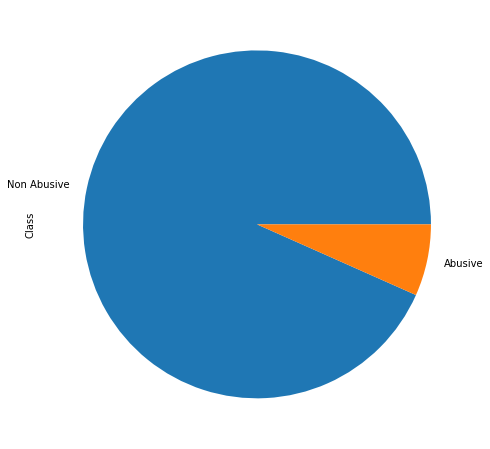

In [8]:
plt.figure(figsize =(8,8))
df['Class'].value_counts().plot.pie()

It's an imbalanced dataset

In [9]:
df1=df.copy()
df1['tot_characters']=df1['content'].apply(len)
df1.head()

,content,Class,tot_characters
0,eat shit\r\n\r\n\r\n\r\n\r\nJohn J Lavorato@ex...,Abusive,245
1,fuck you,Abusive,8
2,Gentlemen:\r\nThe following champagne is avail...,Abusive,628
3,sorry i've taken so long...just been trying to...,Abusive,528
4,asshole\r\n\r\n\r\n\r\n\r\nJohn J Lavorato@exc...,Abusive,224


In [10]:
#  Character statistics for Abusive class
df1[df1['Class']=='Abusive']['tot_characters'].describe()

count     1642.000000
mean      1737.635201
std       2918.776038
min          5.000000
25%        188.250000
50%        613.500000
75%       2213.750000
max      36818.000000
Name: tot_characters, dtype: float64

In [11]:
#  Character statistics for Non-Abusive class
df1[df1['Class']=='Non Abusive']['tot_characters'].describe()

count     23014.000000
mean       1845.730859
std        5608.296341
min           1.000000
25%         279.000000
50%         757.000000
75%        1773.000000
max      275650.000000
Name: tot_characters, dtype: float64

Text(0.5, 1.0, 'KDE Plot')

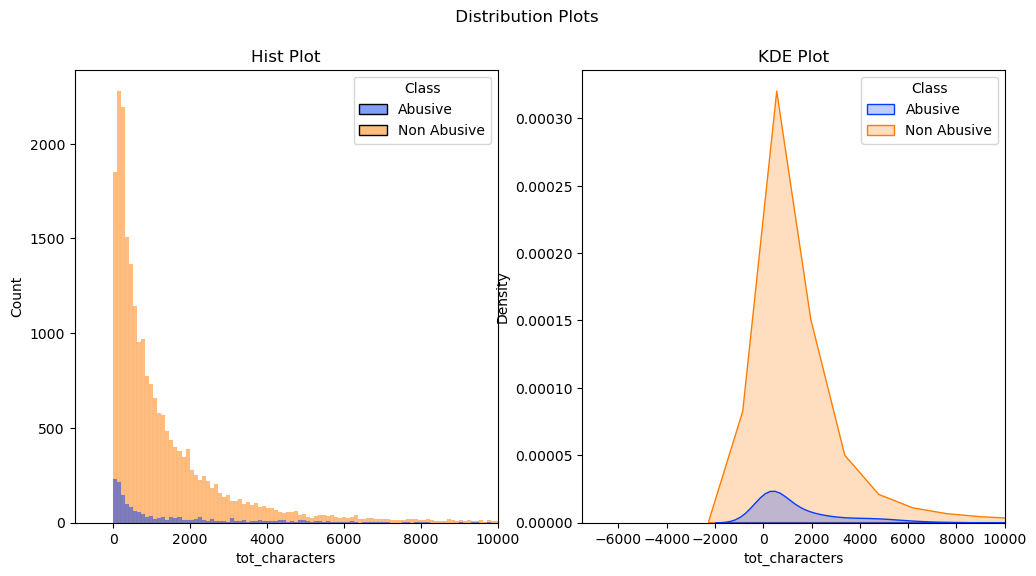

In [12]:
## Histogram and Density Plots tor total characters
import seaborn as sns
fig, ax = plt.subplots(1, 2,dpi=100, figsize=(12, 6))
fig.suptitle(' Distribution Plots')

sns.histplot(ax=ax[0],data=df1, x='tot_characters', hue='Class', kde=False, fill=True, 
            palette=sns.color_palette('bright',n_colors=2), 
            )
ax[0].set_xlim(-1000 ,10000)
ax[0].set_title('Hist Plot')
# Second Plot- KDE Plot

sns.kdeplot(ax=ax[1],data=df1, x='tot_characters', hue='Class',fill=True,
            palette=sns.color_palette('bright',n_colors=2))
ax[1].set_xlim(-7500 ,10000)
ax[1].set_title('KDE Plot')


<AxesSubplot:xlabel='tot_characters', ylabel='Class'>

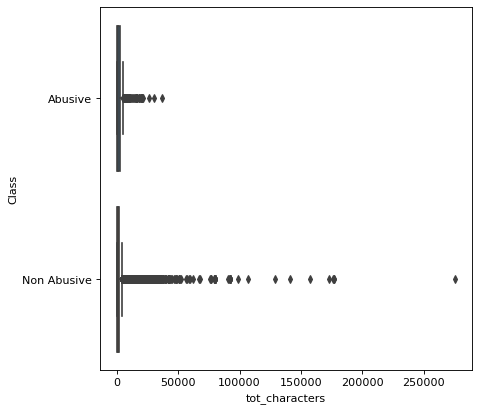

In [13]:
## Box Plot
plt.figure(figsize=(6,6),dpi=80)
sns.boxplot(x=df1['tot_characters'], y=df1['Class'])

## Data Preprocessing

In [17]:
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words
adds= ['subject','image']
sw_spacy.update(adds)

In [18]:
def preprocess_text(text):
    
    # removing email id tags
    text=re.sub('\S*@\S*\s?',' ',text)
    
    # Removing url
    text=re.sub(r'http\S+', ' ',text)
    
    # removing r\n\ pattern
    text=re.sub('[\r\n]+', ' ',text)
    
    # removing numbers and special characters
    text=re.sub('[^A-Za-z ]+', ' ',text)
    
    # removing words beginning with capital letters
    text= re.sub('([^.])( [A-Z]\w*)', r'\1',text)
    
    # Removing words less than lenghth 3
    short = re.compile(r'\W*\b\w{1,3}\b')
    text= short.sub(' ',text)
    
    # Converting to lowercase
    text=text.lower()
    
    # Lemmatize
    lm = WordNetLemmatizer()
    text= lm.lemmatize(text) 
    
    # Stopwords removal
    text = ' '.join([word for word in text.split() if word not in sw_spacy])

    # Blank lines
    text=re.sub(r'^$\n', '', text, flags=re.MULTILINE)
    
    # blank spaces
    text=' '.join([line for line in text.split('\n') if line.strip() != ''])
    #text=' '.join()
    return text

In [19]:
df['cleaned_text']= df['content'].apply(preprocess_text)

In [20]:
# Dropping content column
df.drop('content',axis=1,inplace=True)
df.rename(columns={'cleaned_text':'Text'},inplace=True)
df.head()

,Class,Text
0,Abusive,shit bets clev
1,Abusive,fuck
2,Abusive,gentlemen following champagne available approx...
3,Abusive,sorry taken long trying fend chicks life soooo...
4,Abusive,asshole john cant gambling problem away bills ...


### Word cloud generation

In [21]:
from wordcloud import WordCloud
wc = WordCloud(height=2000, width=2000,max_words=30,background_color='white')

In [22]:
ab_wc = wc.generate(df[df['Class']=='Abusive']['Text'].str.cat(sep=' '))

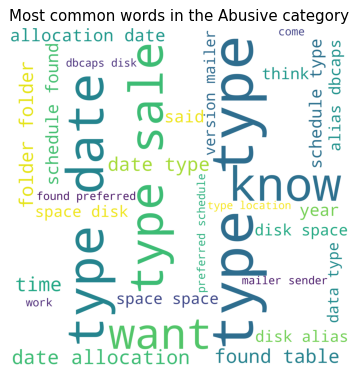

In [23]:
plt.figure(figsize=(5,5),dpi=90)
plt.imshow(ab_wc)
plt.title("Most common words in the Abusive category")
plt.axis('off')
plt.show()

In [24]:
nab_wc = wc.generate(df[df['Class']=='Non Abusive']['Text'].str.cat(sep=' '))

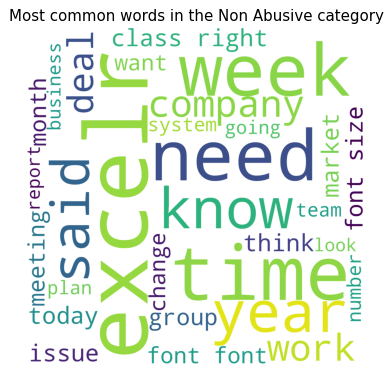

In [25]:
plt.figure(figsize=(5,5),dpi=90)
plt.imshow(nab_wc)
plt.title("Most common words in the Non Abusive category")
plt.axis('off')
plt.show()

In [19]:
# Checking for empty strings in the dataframe post cleaning
count=0
index=[]
for i in range (len(df['Text'])):
    if not(len(df['Text'][i].strip())):
        index.append(i)
        count=count+1
print(count)        

244


In [20]:
# Dropping rows containing empty strings
df.drop(index,inplace=True)

df.reset_index(drop=True,inplace=True)

print('Shape of dataframe after dropping empty strings:',df.shape)

Shape of dataframe after dropping empty strings: (24412, 2)


In [21]:
X= df.iloc[:,1]
y= df.iloc[:,0]

In [22]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,stratify= y,random_state=1)

print('Shape of training data:',(X_train.shape))
print('Shape of testing data:',(X_test.shape))

Shape of training data: (17088,)
Shape of testing data: (7324,)


## Resampling training data using SMOTEN

In [23]:
print('Distribution of y_train before resampling:',Counter(y_train))

# Converting X_train from series to 2D array
X_train= X_train.values.reshape(-1,1)

# Oversampling
oversample = SMOTEN(sampling_strategy='minority')
X_train, y_train = oversample.fit_resample(X_train, y_train)
print('Distribution of y_train after resampling:',Counter(y_train))

Distribution of y_train before resampling: Counter({'Non Abusive': 15941, 'Abusive': 1147})
Distribution of y_train after resampling: Counter({'Non Abusive': 15941, 'Abusive': 15941})


In [24]:
## Label Encoding Y
le= LabelEncoder()
le.fit(y_train)
y_train= le.transform(y_train)
y_test = le.transform(y_test)

print(le.classes_)

['Abusive' 'Non Abusive']


In [25]:
X_train1= X_train.copy()
X_test1= X_test.copy()
y_train1= y_train.copy()
y_test1= y_test.copy()

In [26]:
# Converting 2D array to 1D array

X_train1= X_train1.ravel()
X_test1= X_test1.ravel()

In [27]:
# checking unique features distribution in documents
for i in np.arange(0.01,0.50,0.05):
    
    tf= TfidfVectorizer(min_df= i)
    tf.fit(X_train1)
    tf_features=tf.get_feature_names()
    feature_count= len(tf_features)
    print('Min_df:',np.round(i,3), 'Features present:',feature_count)

Min_df: 0.01 Features present: 551
Min_df: 0.06 Features present: 37
Min_df: 0.11 Features present: 24
Min_df: 0.16 Features present: 20
Min_df: 0.21 Features present: 20
Min_df: 0.26 Features present: 20
Min_df: 0.31 Features present: 20
Min_df: 0.36 Features present: 20
Min_df: 0.41 Features present: 20
Min_df: 0.46 Features present: 20


## Vectorization using TfidfVectorizer

In [28]:
tf= TfidfVectorizer()
tf.fit(X_train1)
tf_features=tf.get_feature_names()
print('Total number of terms/features present:',len(tf_features))

Total number of terms/features present: 47434


In [29]:
X_train1=tf.transform(X_train1)
X_test1=tf.transform(X_test1)

## Model selection and cross validation

In [30]:
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

classifiers={'MNB':MultinomialNB(),
             'SGD':SGDClassifier(),
             'LSVC': LinearSVC()}

In [31]:
from time import time
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

names=['0-Abusive','1-Non Abusive']
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
start = time()
for model_type,model in zip(classifiers.keys(),classifiers.items()):
    
    score=cross_val_score(model[1] ,X_train1,y_train,scoring='precision',cv=cv,n_jobs=-1)
    print(model_type,'\t',np.mean(score).round(3),'\t',np.std(score).round(3))
    model[1].fit(X_train1,y_train)
    pred= model[1].predict(X_test1)
    print('Test data report:')
    print(classification_report(y_test, pred,target_names=names))
    print('*'*30)
end = time()
print('Time taken(s):',round(end-start,3))

MNB 	 0.933 	 0.006
Test data report:
               precision    recall  f1-score   support

    0-Abusive       0.59      0.08      0.14       491
1-Non Abusive       0.94      1.00      0.97      6833

     accuracy                           0.93      7324
    macro avg       0.76      0.54      0.55      7324
 weighted avg       0.91      0.93      0.91      7324

******************************
SGD 	 0.957 	 0.005
Test data report:
               precision    recall  f1-score   support

    0-Abusive       0.92      0.37      0.53       491
1-Non Abusive       0.96      1.00      0.98      6833

     accuracy                           0.96      7324
    macro avg       0.94      0.69      0.75      7324
 weighted avg       0.95      0.96      0.95      7324

******************************
LSVC 	 0.973 	 0.004
Test data report:
               precision    recall  f1-score   support

    0-Abusive       0.91      0.66      0.77       491
1-Non Abusive       0.98      1.00      0.99  

## Checking the effect of number of features on f1-score

In [32]:
X_train2= X_train.copy()
X_test2= X_test.copy()
y_train2= y_train.copy()
y_test2= y_test.copy()

In [33]:
# Converting 2D array to 1D array
X_train2= X_train2.ravel()
X_test2= X_test2.ravel()

In [34]:
start = time()
num_features=[10000,20000,30000,40000,47000]
for i in num_features:
    
    tf= TfidfVectorizer(max_features=i)
    tf.fit(X_train2)
    X_train_tf=tf.transform(X_train2)
    print('Number of features used:',i)
    for model_type,model in zip(classifiers.keys(),classifiers.items()):
        score=cross_val_score(model[1] ,X_train_tf,y_train2,scoring='f1',cv=cv,n_jobs=-1)
        print(model_type,'\t',np.mean(score).round(3),'\t',np.std(score).round(3))
    print('*'*30)
end = time()   
print('Time taken(s):',round(end-start,3))

Number of features used: 10000
MNB 	 0.964 	 0.003
SGD 	 0.978 	 0.003
LSVC 	 0.984 	 0.002
******************************
Number of features used: 20000
MNB 	 0.964 	 0.003
SGD 	 0.977 	 0.003
LSVC 	 0.984 	 0.002
******************************
Number of features used: 30000
MNB 	 0.964 	 0.003
SGD 	 0.977 	 0.003
LSVC 	 0.984 	 0.002
******************************
Number of features used: 40000
MNB 	 0.964 	 0.003
SGD 	 0.977 	 0.003
LSVC 	 0.984 	 0.002
******************************
Number of features used: 47000
MNB 	 0.964 	 0.003
SGD 	 0.977 	 0.003
LSVC 	 0.984 	 0.002
******************************
Time taken(s): 160.051


## Final model building with LSVC

In [35]:
X_train= X_train.ravel()
X_test= X_test.ravel()

In [36]:
tf= TfidfVectorizer(max_features=40000)
tf.fit(X_train)
X_train=tf.transform(X_train)
X_test=tf.transform(X_test)

In [37]:
lsvc= LinearSVC()
lsvc.fit(X_train,y_train)

lsvc_pred= lsvc.predict(X_test)

names=['0-Abusive','1-Non Abusive']
print(classification_report(y_test1, lsvc_pred,target_names=names))

               precision    recall  f1-score   support

    0-Abusive       0.91      0.66      0.76       491
1-Non Abusive       0.98      1.00      0.99      6833

     accuracy                           0.97      7324
    macro avg       0.95      0.83      0.87      7324
 weighted avg       0.97      0.97      0.97      7324



### So with LSVC model we are getting precision of 0.91 and recall 0.66 for abusive class